# London Fire Incidents Dimensionality Reduction

In [1]:
%matplotlib inline 
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Downloading and loadng the data

In [2]:
# Loading the data
# import data_download

data_dir = "LFB-data"
# LFB_data = pd.read_csv(os.path.join(data_dir, "LFB Incident data - Datastore - with notional cost and UPRN from January 2009.csv"))
LFB_data = pd.read_csv(os.path.join(data_dir, "lfb_incident.csv"))

# Total memory used
print(f'Total Memory Used : {round(LFB_data.memory_usage(deep=True).sum()/(1024*1024), 2)} MB')
LFB_data.head()

Total Memory Used : 2091.97 MB


,IncidentNumber,DateOfCall,CalYear,TimeOfCall,HourOfCall,IncidentGroup,StopCodeDescription,SpecialServiceType,PropertyCategory,PropertyType,...,FirstPumpArriving_AttendanceTime,FirstPumpArriving_DeployedFromStation,SecondPumpArriving_AttendanceTime,SecondPumpArriving_DeployedFromStation,NumStationsWithPumpsAttending,NumPumpsAttending,PumpCount,PumpHoursRoundUp,Notional Cost (£),NumCalls
0,235138081,01 Jan 2009,2009,00:00:37,0,Special Service,Special Service,RTC,Road Vehicle,Car,...,319.0,Battersea,342.0,Clapham,2.0,2.0,2.0,1.0,255.0,1.0
1,1091,01 Jan 2009,2009,00:00:46,0,Special Service,Special Service,Assist other agencies,Outdoor,Lake/pond/reservoir,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,2091,01 Jan 2009,2009,00:03:00,0,Fire,Secondary Fire,NaN,Outdoor,Road surface/pavement,...,308.0,Edmonton,NaN,NaN,1.0,1.0,1.0,1.0,255.0,2.0
3,3091,01 Jan 2009,2009,00:04:27,0,Fire,Secondary Fire,NaN,Outdoor,Domestic garden (vegetation not equipment),...,210.0,Hillingdon,NaN,NaN,1.0,1.0,1.0,1.0,255.0,2.0
4,5091,01 Jan 2009,2009,00:05:39,0,Fire,Secondary Fire,NaN,Outdoor,Cycle path/public footpath/bridleway,...,233.0,Holloway,250.0,Holloway,1.0,2.0,2.0,1.0,255.0,1.0


### Primary Data analysis

In [3]:
LFB_data.shape

(1465060, 39)

In [4]:
LFB_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465060 entries, 0 to 1465059
Data columns (total 39 columns):
 #   Column                                  Non-Null Count    Dtype  
---  ------                                  --------------    -----  
 0   IncidentNumber                          1465060 non-null  object 
 1   DateOfCall                              1465060 non-null  object 
 2   CalYear                                 1465060 non-null  int64  
 3   TimeOfCall                              1465060 non-null  object 
 4   HourOfCall                              1465060 non-null  int64  
 5   IncidentGroup                           1465060 non-null  object 
 6   StopCodeDescription                     1465060 non-null  object 
 7   SpecialServiceType                      459204 non-null   object 
 8   PropertyCategory                        1465060 non-null  object 
 9   PropertyType                            1465060 non-null  object 
 10  AddressQualifier              

Yellow - Missing Values
Blue - Non Missing


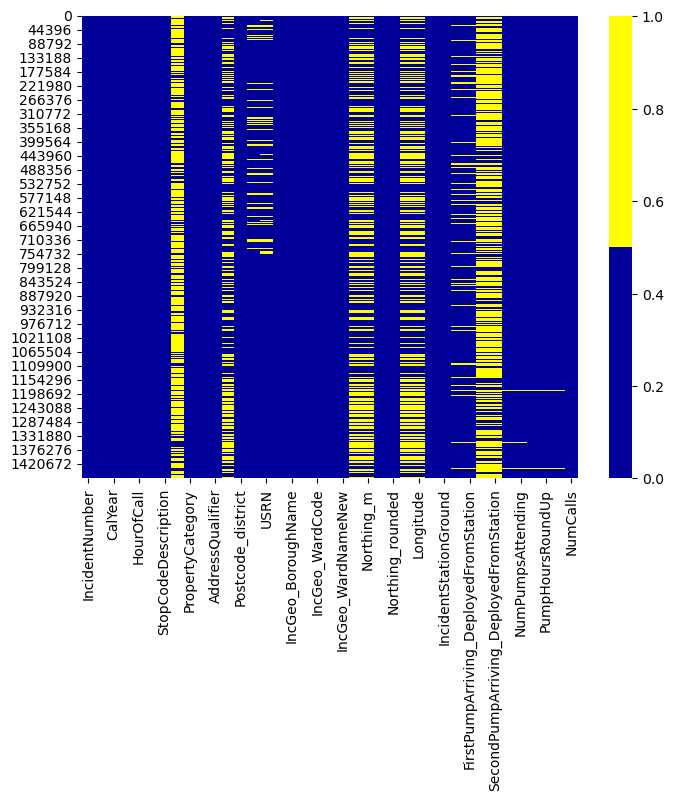

In [5]:
# Lets see if the data has missing values.

plt.figure(figsize = (8,6))
cols = LFB_data.columns[:]
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sns.heatmap(LFB_data[cols].isnull(), cmap=sns.color_palette(colours))
print("Yellow - Missing Values\nBlue - Non Missing")

We can see that there are missing values

In [6]:
# Lets see whath columns have the missing values

LFB_data.isnull().sum()

IncidentNumber                                  0
DateOfCall                                      0
CalYear                                         0
TimeOfCall                                      0
HourOfCall                                      0
IncidentGroup                                   0
StopCodeDescription                             0
SpecialServiceType                        1005856
PropertyCategory                                0
PropertyType                                    0
AddressQualifier                                0
Postcode_full                              706377
Postcode_district                               0
UPRN                                       141333
USRN                                       162871
IncGeo_BoroughCode                              0
IncGeo_BoroughName                              0
ProperCase                                      0
IncGeo_WardCode                                 4
IncGeo_WardName                                 4


## Exploratory data analysis

### Numerical data

In [7]:
# select numeric columns
df_numeric = LFB_data.select_dtypes(include=[np.number])

print("Numeric data shape : ",df_numeric.shape)
df_numeric.columns.values

Numeric data shape :  (1465060, 18)


array(['CalYear', 'HourOfCall', 'UPRN', 'USRN', 'Easting_m', 'Northing_m',
       'Easting_rounded', 'Northing_rounded', 'Latitude', 'Longitude',
       'FirstPumpArriving_AttendanceTime',
       'SecondPumpArriving_AttendanceTime',
       'NumStationsWithPumpsAttending', 'NumPumpsAttending', 'PumpCount',
       'PumpHoursRoundUp', 'Notional Cost (£)', 'NumCalls'], dtype=object)

In [8]:
df_numeric.describe().T.apply(lambda s: s.apply('{0:.2f}'.format))

,count,mean,std,min,25%,50%,75%,max
CalYear,1465060.00,2015.06,4.02,2009.00,2011.00,2015.00,2019.00,2022.00
HourOfCall,1465060.00,13.50,6.23,0.00,9.00,14.00,19.00,23.00
UPRN,1323727.00,22914449862.27,48499019353.25,0.00,0.00,0.00,10022798749.00,200004439642.00
USRN,1302189.00,20285674.47,4372908.42,0.00,20400937.00,21201245.00,22101434.00,99990422.00
Easting_m,758683.00,530643.29,10316.60,503582.00,525228.00,530802.00,536834.00,560925.00
Northing_m,758683.00,180365.93,7434.10,155998.00,175995.00,180984.00,184936.00,200906.00
Easting_rounded,1465060.00,530682.48,9718.90,503550.00,525250.00,530950.00,536350.00,611150.00
Northing_rounded,1465060.00,180510.71,7340.14,155950.00,176150.00,181050.00,185150.00,302450.00
Latitude,758683.00,51.47,1.32,0.00,51.47,51.51,51.55,51.69
Longitude,758683.00,-0.12,0.15,-0.51,-0.20,-0.12,-0.03,0.32


We can tell from the data above that there are outliers in the numeric data.
For instance, there are values that have a very huge diffrence between the 75th percentile and maximum value

#### Numerical data visualization

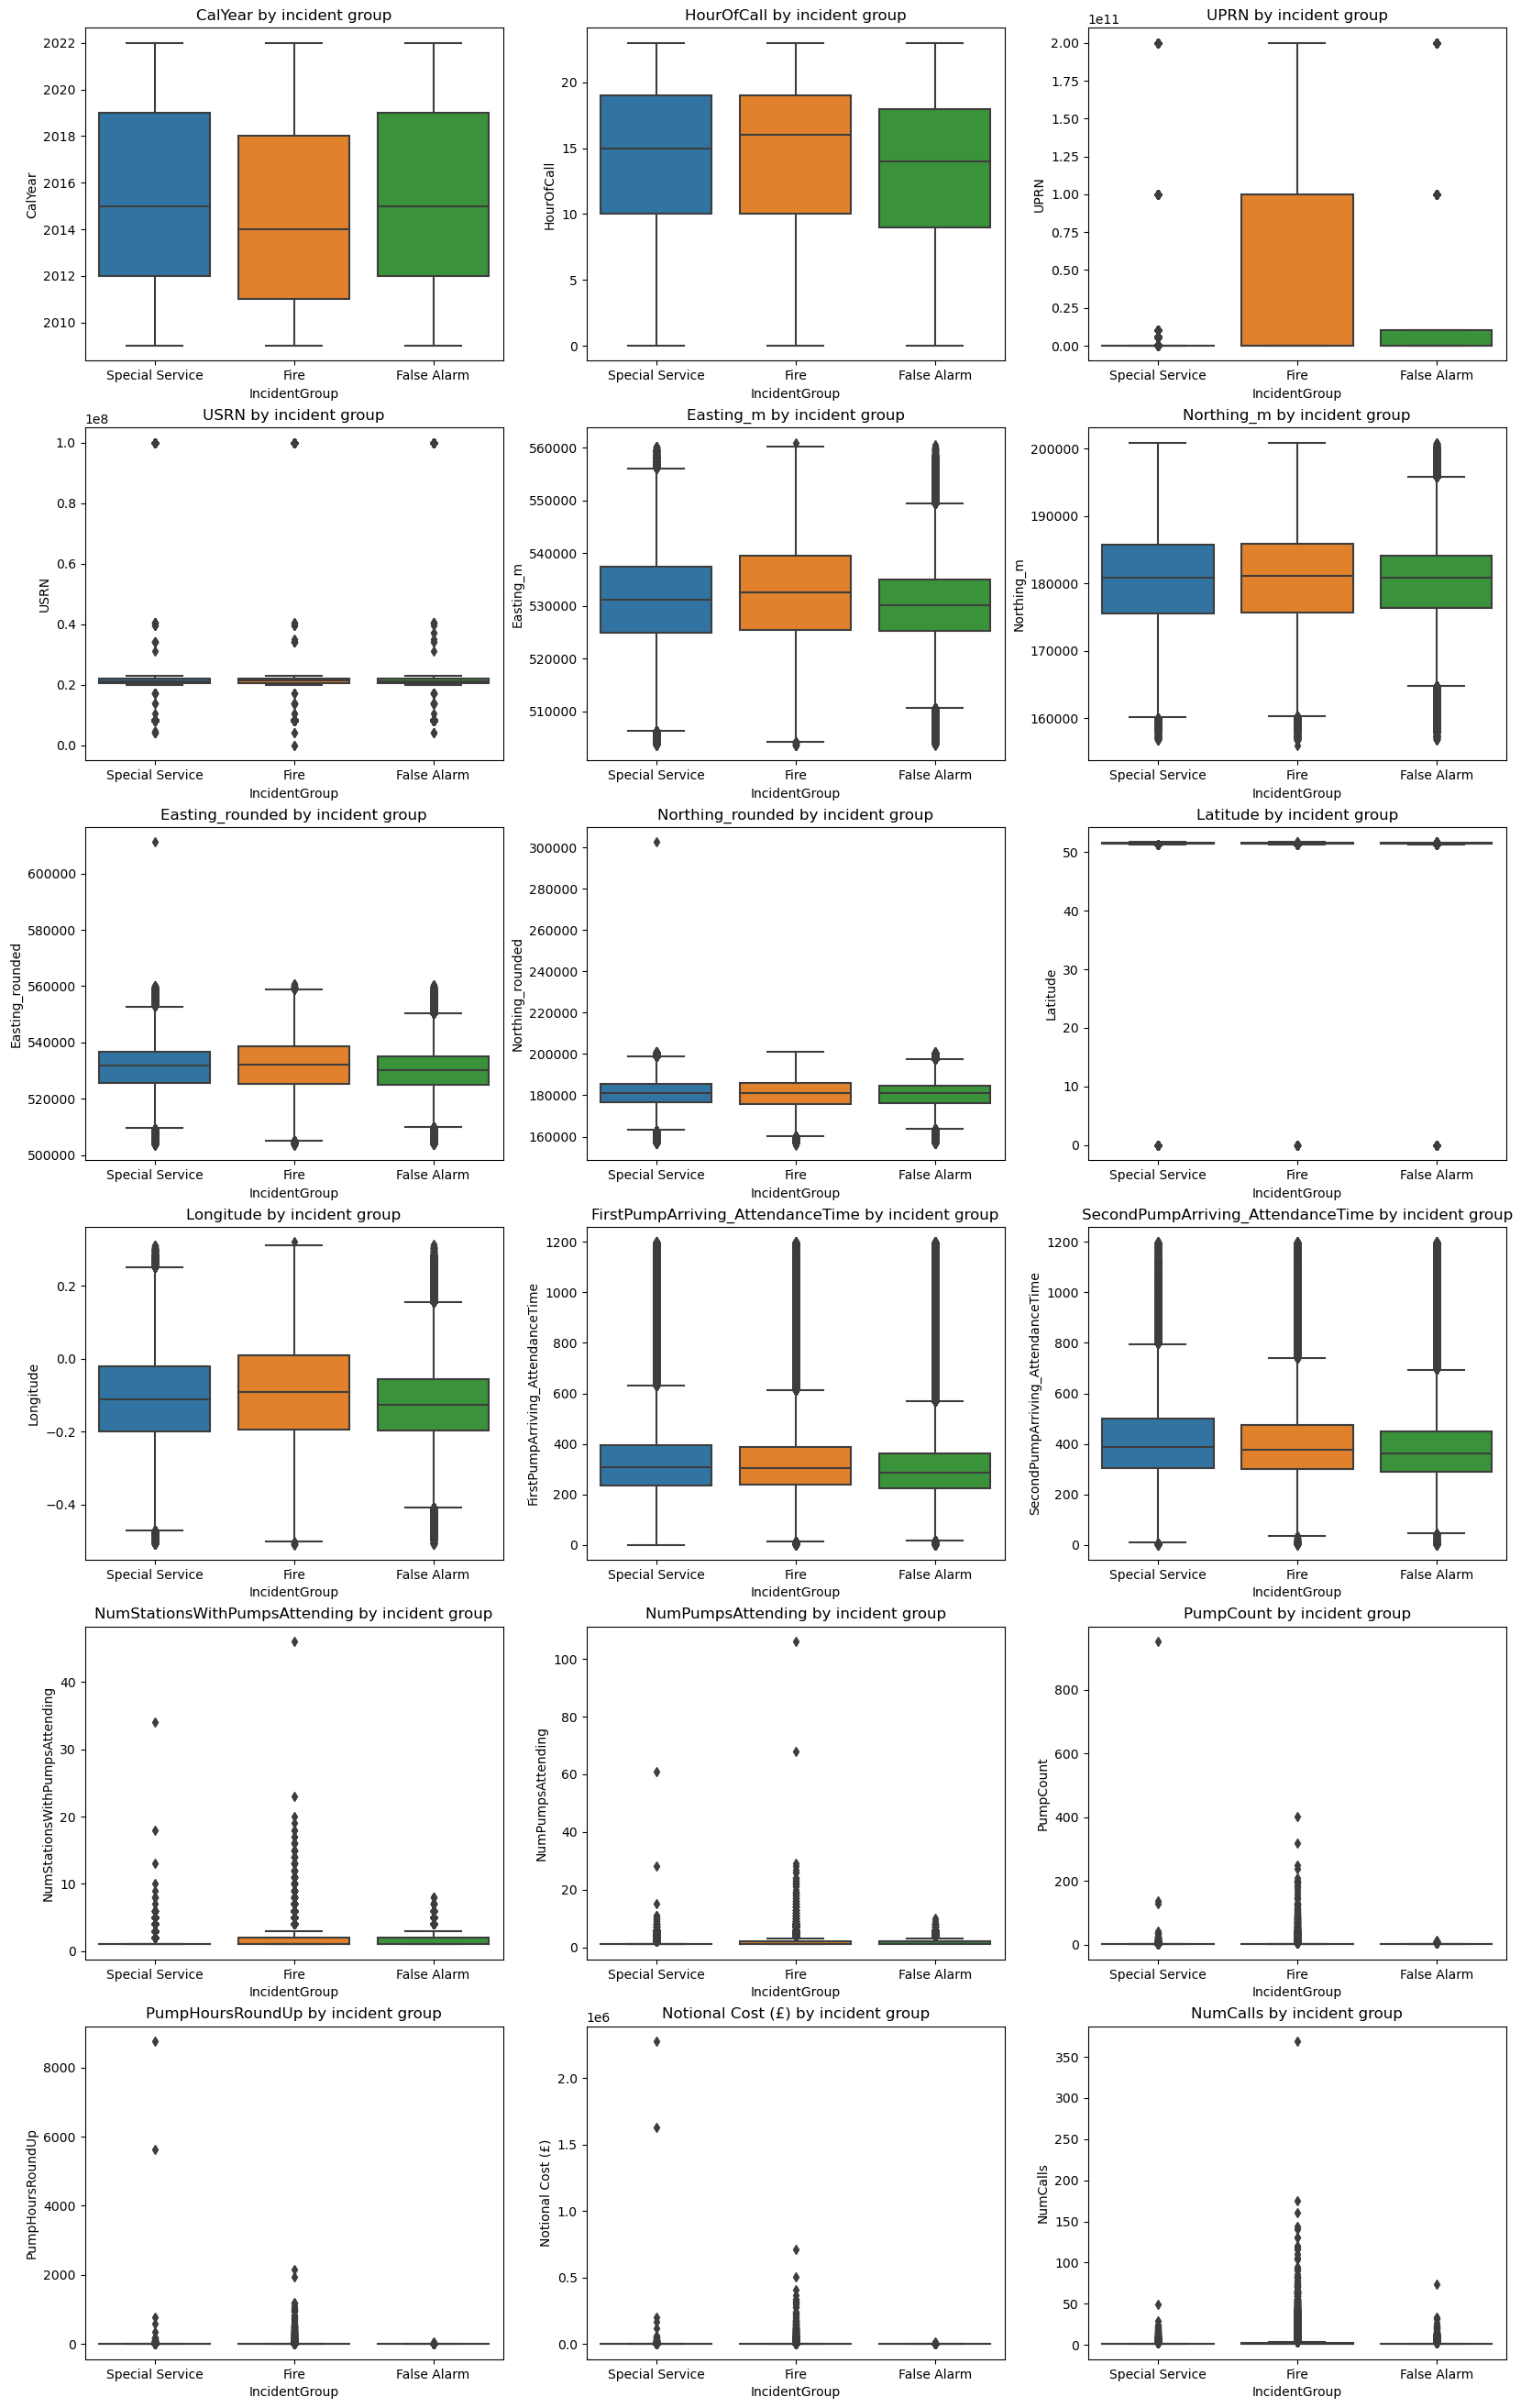

In [9]:
fig = plt.figure(figsize= (20,50))

for i in range(len(df_numeric.columns)):
    column = df_numeric.columns[i]
    sub = fig.add_subplot(9,3, i+1)
    chart = sns.boxplot(data=df_numeric, y=column, x = LFB_data["IncidentGroup"])
    chart.set_title(column + " by incident group")

#### Missing values on Numeric data

In [10]:
# Check for any missing values
print("Number of cols with Missing Vals: ",df_numeric.isna().any().sum())
display(df_numeric.isna().sum())

Number of cols with Missing Vals:  14


CalYear                                   0
HourOfCall                                0
UPRN                                 141333
USRN                                 162871
Easting_m                            706377
Northing_m                           706377
Easting_rounded                           0
Northing_rounded                          0
Latitude                             706377
Longitude                            706377
FirstPumpArriving_AttendanceTime     119752
SecondPumpArriving_AttendanceTime    939563
NumStationsWithPumpsAttending         10781
NumPumpsAttending                     10781
PumpCount                              8182
PumpHoursRoundUp                       8443
Notional Cost (£)                      8443
NumCalls                               1844
dtype: int64

<h6>We need to fix the missing values to cluster around the mean value<br>We will consider randomizing the missing values between 30% and 70%</h6>

#### Missing values

In [13]:

for i in df_numeric[['UPRN', 'USRN', 'Easting_m', 'Northing_m','Easting_rounded', 'Northing_rounded',
                    'FirstPumpArriving_AttendanceTime','SecondPumpArriving_AttendanceTime',
                    'NumStationsWithPumpsAttending', 'NumPumpsAttending', 'PumpCount',
                    'PumpHoursRoundUp', 'Notional Cost (£)', 'NumCalls']]:
    df_numeric.fillna(0, inplace=True)
    # Set 30 and 70th percentile and round off to 2
    rand_30_70 = random.uniform(round(np.percentile(df_numeric[i],30),2), round(np.percentile(df_numeric[i],70),2)) 
    for j in i:
        if j == 0:
            df_numeric.replace(to_replace=0, value=rand_30_70, inplace=True)
            

#### Outliers in numerical data

In [14]:
for i in df_numeric.columns:
    df_numeric.fillna(df_numeric[i].mode()[0], inplace = True)
    highest_val = df_numeric[i].mean() + 3*df_numeric[i].std()
    lowest_val = df_numeric[i].mean() - 3*df_numeric[i].std()
    print(f"Range for {i} : ", round(lowest_val,2), " to ",round(highest_val,2))
    
#     Trimming the outliers
    df_numeric[i]= np.where(df_numeric[i]>highest_val, highest_val,
                           np.where(df_numeric[i]<lowest_val, lowest_val,
                                   df_numeric[i]))
#     (df_numeric[i]>=lowest_val)&(df_numeric[i]<=highest_val)

print( "\n","*"*120)
df_numeric.describe().T.apply(lambda s: s.apply('{0:.2f}'.format))

Range for CalYear :  2003.0  to  2027.12
Range for HourOfCall :  -5.2  to  32.2
Range for UPRN :  -119078422079.01  to  160486249707.68
Range for USRN :  -4749397.31  to  40810421.64
Range for Easting_m :  -520975.26  to  1070563.74
Range for Northing_m :  -177449.71  to  364255.11
Range for Easting_rounded :  501525.79  to  559839.16
Range for Northing_rounded :  158490.28  to  202531.14
Range for Latitude :  -50.56  to  103.87
Range for Longitude :  -0.43  to  0.31
Range for FirstPumpArriving_AttendanceTime :  -186.22  to  769.74
Range for SecondPumpArriving_AttendanceTime :  -489.26  to  771.71
Range for NumStationsWithPumpsAttending :  -0.65  to  3.35
Range for NumPumpsAttending :  -0.95  to  4.04
Range for PumpCount :  -3.28  to  6.45
Range for PumpHoursRoundUp :  -29.24  to  31.93
Range for Notional Cost (£) :  -8172.46  to  8986.96
Range for NumCalls :  -3.13  to  5.79

 *************************************************************************************************************

,count,mean,std,min,25%,50%,75%,max
CalYear,1465060.00,2015.06,4.02,2009.00,2011.00,2015.00,2019.00,2022.00
HourOfCall,1465060.00,13.50,6.23,0.00,9.00,14.00,19.00,23.00
UPRN,1465060.00,19458875140.81,42097424614.83,0.00,0.00,0.00,10008785157.00,160486249707.68
USRN,1465060.00,17993390.07,7332716.00,0.00,20101495.00,20950335.00,22000900.00,40810421.64
Easting_m,1465060.00,274794.24,265256.50,0.00,0.00,509531.00,531132.00,560925.00
Northing_m,1465060.00,93402.70,90284.14,0.00,0.00,165439.00,181128.00,200906.00
Easting_rounded,1465060.00,530682.44,9718.68,503550.00,525250.00,530950.00,536350.00,559839.16
Northing_rounded,1465060.00,180511.07,7338.16,158490.28,176150.00,181050.00,185150.00,202531.14
Latitude,1465060.00,26.66,25.74,0.00,0.00,51.37,51.51,51.69
Longitude,1465060.00,-0.06,0.12,-0.43,-0.12,0.00,0.00,0.31


In [15]:
df_numeric.isnull().sum()

CalYear                              0
HourOfCall                           0
UPRN                                 0
USRN                                 0
Easting_m                            0
Northing_m                           0
Easting_rounded                      0
Northing_rounded                     0
Latitude                             0
Longitude                            0
FirstPumpArriving_AttendanceTime     0
SecondPumpArriving_AttendanceTime    0
NumStationsWithPumpsAttending        0
NumPumpsAttending                    0
PumpCount                            0
PumpHoursRoundUp                     0
Notional Cost (£)                    0
NumCalls                             0
dtype: int64

### Categorical Data

In [16]:
df_categorical = LFB_data.select_dtypes(exclude=[np.number])
print(df_categorical.shape)
print( "\n","-"*120)
df_categorical.columns.values

(1465060, 21)

 ------------------------------------------------------------------------------------------------------------------------


array(['IncidentNumber', 'DateOfCall', 'TimeOfCall', 'IncidentGroup',
       'StopCodeDescription', 'SpecialServiceType', 'PropertyCategory',
       'PropertyType', 'AddressQualifier', 'Postcode_full',
       'Postcode_district', 'IncGeo_BoroughCode', 'IncGeo_BoroughName',
       'ProperCase', 'IncGeo_WardCode', 'IncGeo_WardName',
       'IncGeo_WardNameNew', 'FRS', 'IncidentStationGround',
       'FirstPumpArriving_DeployedFromStation',
       'SecondPumpArriving_DeployedFromStation'], dtype=object)

In [17]:
df_categorical.sample(10)

,IncidentNumber,DateOfCall,TimeOfCall,IncidentGroup,StopCodeDescription,SpecialServiceType,PropertyCategory,PropertyType,AddressQualifier,Postcode_full,...,IncGeo_BoroughCode,IncGeo_BoroughName,ProperCase,IncGeo_WardCode,IncGeo_WardName,IncGeo_WardNameNew,FRS,IncidentStationGround,FirstPumpArriving_DeployedFromStation,SecondPumpArriving_DeployedFromStation
368704,198449111,10 Dec 2011,23:09:59,Fire,Primary Fire,NaN,Dwelling,Purpose Built Flats/Maisonettes - Up to 3 stor...,Correct incident location,NaN,...,E09000002,BARKING AND DAGENHAM,Barking And dagenham,E05000026,Abbey,Abbey,London,Barking,Barking,Barking
605746,34205141,20 Mar 2014,22:21:58,Special Service,Special Service,Flooding,Dwelling,Converted Flat/Maisonette - Up to 2 storeys,Within same building,NaN,...,E09000019,ISLINGTON,Islington,E05000377,Mildmay,Mildmay,London,Islington,Islington,NaN
507940,42452131,06 Apr 2013,09:52:06,False Alarm,False alarm - Good intent,NaN,Dwelling,House - single occupancy,Correct incident location,NaN,...,E09000010,ENFIELD,Enfield,E05000204,Lower Edmonton,Lower Edmonton,London,Edmonton,Edmonton,NaN
1066582,136355-24092018,24 Sep 2018,20:54:11,False Alarm,False alarm - Good intent,NaN,Dwelling,House - single occupancy,Correct incident location,NaN,...,E09000004,BEXLEY,Bexley,E05011230,Sidcup,Sidcup,London,Sidcup,Sidcup,Sidcup
726098,78018151,22 Jun 2015,02:15:03,False Alarm,AFA,NaN,Dwelling,Purpose Built Flats/Maisonettes - 4 to 9 storeys,Correct incident location,NaN,...,E09000012,HACKNEY,Hackney,E05009377,Hoxton East & Shoreditch,Hoxton East & Shoreditch,London,Shoreditch,Shoreditch,Whitechapel
962164,132440-01102017,01 Oct 2017,23:57:01,Special Service,Special Service,RTC,Road Vehicle,Car,In street outside gazetteer location,E3 3QX,...,E09000030,TOWER HAMLETS,Tower Hamlets,E05009322,BROMLEY SOUTH,BROMLEY SOUTH,London,Poplar,Poplar,Millwall
676773,165405141,10 Dec 2014,20:05:33,Fire,Primary Fire,NaN,Road Vehicle,Motorcycle,In street close to gazetteer location,E2 8RB,...,E09000012,HACKNEY,Hackney,E05009375,Haggerston,Haggerston,London,Bethnal Green,Bethnal Green,NaN
207511,129734101,31 Jul 2010,19:32:46,Special Service,Special Service,Lift Release,Non Residential,Large supermarket,Correct incident location,HA7 4DA,...,E09000015,HARROW,Harrow,E05000303,Stanmore Park,Stanmore Park,London,Stanmore,NaN,NaN
406943,53980121,19 Apr 2012,00:02:59,Fire,Primary Fire,NaN,Dwelling,House - single occupancy,Correct incident location,NaN,...,E09000024,MERTON,Merton,E05000463,Lavender Fields,Lavender Fields,London,Mitcham,NaN,NaN
980019,161956-02122017,02 Dec 2017,15:34:36,False Alarm,AFA,NaN,Other Residential,Retirement/Old Persons Home,Correct incident location,E14 6PX,...,E09000030,TOWER HAMLETS,Tower Hamlets,E05009325,LANSBURY,LANSBURY,London,Poplar,Millwall,NaN


In [18]:
print(df_categorical['IncGeo_WardName'] == df_categorical['IncGeo_WardNameNew'])
print('-'*50)

0          True
1          True
2          True
3          True
4          True
           ... 
1465055    True
1465056    True
1465057    True
1465058    True
1465059    True
Length: 1465060, dtype: bool
--------------------------------------------------


In [19]:
# Drop the incidentnumber, postcode_full,  column since we really dont need it
df_categorical.drop(['IncidentNumber', 'Postcode_full', 'IncGeo_WardNameNew'], axis = 1, inplace=True)

# Create a new column from the DateOfCall column.
df_categorical['MonthOfCall'] = df_categorical['DateOfCall'].apply(lambda x: x.split(" ")[1])
df_categorical['YearOfCall'] = df_categorical['DateOfCall'].apply(lambda x: x.split(" ")[2])
df_categorical.drop('DateOfCall', axis=1, inplace = True)


# Create a new column from the DateOfCall column.
df_categorical['HourOfCall'] = df_categorical['TimeOfCall'].apply(lambda x: x.split(":")[0])
df_categorical.drop('TimeOfCall', axis=1, inplace = True)

In [20]:
# Show new dataframe

df_categorical

,IncidentGroup,StopCodeDescription,SpecialServiceType,PropertyCategory,PropertyType,AddressQualifier,Postcode_district,IncGeo_BoroughCode,IncGeo_BoroughName,ProperCase,IncGeo_WardCode,IncGeo_WardName,FRS,IncidentStationGround,FirstPumpArriving_DeployedFromStation,SecondPumpArriving_DeployedFromStation,MonthOfCall,YearOfCall,HourOfCall
0,Special Service,Special Service,RTC,Road Vehicle,Car,In street close to gazetteer location,SW11,E09000032,WANDSWORTH,Wandsworth,E05000620,Queenstown,London,Battersea,Battersea,Clapham,Jan,2009,00
1,Special Service,Special Service,Assist other agencies,Outdoor,Lake/pond/reservoir,Open land/water - nearest gazetteer location,SE1,E09000022,LAMBETH,Lambeth,E05000416,Bishop's,London,Lambeth,NaN,NaN,Jan,2009,00
2,Fire,Secondary Fire,NaN,Outdoor,Road surface/pavement,In street outside gazetteer location,N9,E09000010,ENFIELD,Enfield,E05000201,Haselbury,London,Edmonton,Edmonton,NaN,Jan,2009,00
3,Fire,Secondary Fire,NaN,Outdoor,Domestic garden (vegetation not equipment),On land associated with building,UB10,E09000017,HILLINGDON,Hillingdon,E05000332,Hillingdon East,London,Hillingdon,Hillingdon,NaN,Jan,2009,00
4,Fire,Secondary Fire,NaN,Outdoor,Cycle path/public footpath/bridleway,In street outside gazetteer location,N7,E09000019,ISLINGTON,Islington,E05000375,Holloway,London,Holloway,Holloway,Holloway,Jan,2009,00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465055,False Alarm,AFA,NaN,Non Residential,Warehouse,Correct incident location,TW6,E09000017,HILLINGDON,Hillingdon,E05013570,HEATHROW VILLAGES,London,Heathrow,Feltham,NaN,Jun,2022,23
1465056,Special Service,Special Service,Effecting entry/exit,Dwelling,Purpose Built Flats/Maisonettes - Up to 3 stor...,Correct incident location,N19,E09000019,ISLINGTON,Islington,E05013712,TOLLINGTON,London,Holloway,Kentish Town,NaN,Jun,2022,23
1465057,False Alarm,AFA,NaN,Non Residential,Pub/wine bar/bar,Correct incident location,UB4,E09000017,HILLINGDON,Hillingdon,E05013582,WOOD END,London,Hillingdon,Hillingdon,NaN,Jun,2022,23
1465058,False Alarm,False alarm - Good intent,NaN,Dwelling,Purpose Built Flats/Maisonettes - 4 to 9 storeys,Correct incident location,E1W,E09000030,TOWER HAMLETS,Tower Hamlets,E05009332,SHADWELL,London,Shadwell,Shadwell,NaN,Jun,2022,23


In [21]:
# Show unique values for each categorcal variable

df_categorical.nunique()

IncidentGroup                                3
StopCodeDescription                         10
SpecialServiceType                          21
PropertyCategory                             9
PropertyType                               291
AddressQualifier                            11
Postcode_district                          328
IncGeo_BoroughCode                          33
IncGeo_BoroughName                          33
ProperCase                                  33
IncGeo_WardCode                           1274
IncGeo_WardName                           1560
FRS                                          1
IncidentStationGround                      103
FirstPumpArriving_DeployedFromStation      114
SecondPumpArriving_DeployedFromStation     113
MonthOfCall                                 12
YearOfCall                                  14
HourOfCall                                  24
dtype: int64

### Joining dataframes

In [22]:
final_df = pd.concat([df_numeric, df_categorical], axis = 1)
final_df.shape

(1465060, 37)

In [23]:
final_df.sample(7)

,CalYear,HourOfCall,UPRN,USRN,Easting_m,Northing_m,Easting_rounded,Northing_rounded,Latitude,Longitude,...,ProperCase,IncGeo_WardCode,IncGeo_WardName,FRS,IncidentStationGround,FirstPumpArriving_DeployedFromStation,SecondPumpArriving_DeployedFromStation,MonthOfCall,YearOfCall,HourOfCall
1363133,2021.0,1.0,0.000000e+00,21606857.0,0.0,0.0,532350.0,184050.0,0.000000,0.000000,...,Islington,E05000380,ST. PETER'S,London,Islington,Islington,NaN,Aug,2021,01
556566,2013.0,18.0,0.000000e+00,0.0,547043.0,185695.0,547050.0,185650.0,51.550990,0.119433,...,Barking And dagenham,E05000028,Becontree,London,Dagenham,Dagenham,NaN,Sep,2013,18
798680,2016.0,15.0,1.000220e+11,22001851.0,535561.0,173129.0,535550.0,173150.0,51.440940,-0.050888,...,Lewisham,E05000450,PERRY VALE,London,Forest Hill,Forest Hill,NaN,Mar,2016,15
363084,2011.0,16.0,0.000000e+00,20012860.0,0.0,0.0,524750.0,195450.0,0.000000,0.000000,...,Barnet,E05000060,Underhill,London,Barnet,NaN,NaN,Nov,2011,16
93497,2009.0,9.0,1.000914e+10,22860850.0,537730.0,192878.0,537750.0,192850.0,51.617884,-0.011983,...,Waltham Forest,E05000602,Larkswood,London,Chingford,Chingford,NaN,Sep,2009,09
945310,2017.0,6.0,3.402705e+07,21001300.0,523231.0,178636.0,523250.0,178650.0,51.493248,-0.226283,...,Hammersmith And fulham,E05000256,HAMMERSMITH BROADWAY,London,Hammersmith,NaN,NaN,Aug,2017,06
1069222,2018.0,13.0,1.002323e+10,22001978.0,538970.0,172784.0,538950.0,172750.0,51.437015,-0.002005,...,Lewisham,E05000440,CATFORD SOUTH,London,Lewisham,Lewisham,NaN,Oct,2018,13


### One hot encoding

In [24]:
final_df = pd.get_dummies(final_df)
final_df.tail()

,CalYear,HourOfCall,UPRN,USRN,Easting_m,Northing_m,Easting_rounded,Northing_rounded,Latitude,Longitude,...,HourOfCall_14,HourOfCall_15,HourOfCall_16,HourOfCall_17,HourOfCall_18,HourOfCall_19,HourOfCall_20,HourOfCall_21,HourOfCall_22,HourOfCall_23
1465055,2022.0,23.0,1.000995e+10,21401748.0,506341.0,174670.0,506350.0,174650.0,51.461026,-0.428787,...,0,0,0,0,0,0,0,0,0,1
1465056,2022.0,23.0,0.000000e+00,21606466.0,0.0,0.0,530250.0,186950.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,1
1465057,2022.0,23.0,1.000234e+11,21402032.0,508781.0,181838.0,508750.0,181850.0,51.524992,-0.428787,...,0,0,0,0,0,0,0,0,0,1
1465058,2022.0,23.0,0.000000e+00,22700543.0,0.0,0.0,535650.0,180950.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,1
1465059,2022.0,23.0,0.000000e+00,20400239.0,0.0,0.0,524350.0,185050.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,1


# Dimensionality reduction

In [27]:
random.seed(10)
rand_num=random.sample(range(len(final_df)), 10000)
rand_num[:10]

[1198318,
 68335,
 899445,
 1012005,
 1212345,
 31105,
 432219,
 970101,
 1030323,
 582003]

In [28]:
working_df = final_df.iloc[rand_num]
working_df.sample(10)

,CalYear,HourOfCall,UPRN,USRN,Easting_m,Northing_m,Easting_rounded,Northing_rounded,Latitude,Longitude,...,HourOfCall_14,HourOfCall_15,HourOfCall_16,HourOfCall_17,HourOfCall_18,HourOfCall_19,HourOfCall_20,HourOfCall_21,HourOfCall_22,HourOfCall_23
141132,2010.0,15.0,0.000000e+00,22700067.0,0.0,0.0,537650.0,178750.0,0.000000,0.000000,...,0,1,0,0,0,0,0,0,0,0
1443196,2022.0,22.0,1.604862e+11,20801232.0,540606.0,178462.0,540650.0,178450.0,51.487634,0.023772,...,0,0,0,0,0,0,0,0,1,0
623862,2014.0,13.0,0.000000e+00,22102232.0,0.0,0.0,525850.0,171550.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
226303,2010.0,18.0,0.000000e+00,21606599.0,0.0,0.0,530050.0,185250.0,0.000000,0.000000,...,0,0,0,0,1,0,0,0,0,0
17897,2009.0,10.0,0.000000e+00,20401354.0,0.0,0.0,524850.0,184750.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
917049,2017.0,17.0,1.009368e+10,20101463.0,548451.0,178502.0,548450.0,178550.0,51.485991,0.136700,...,0,0,0,1,0,0,0,0,0,0
661453,2014.0,18.0,1.000234e+11,21501058.0,514316.0,175421.0,514350.0,175450.0,51.466222,-0.355681,...,0,0,0,0,1,0,0,0,0,0
624963,2014.0,14.0,0.000000e+00,22004055.0,0.0,0.0,537350.0,171750.0,0.000000,0.000000,...,1,0,0,0,0,0,0,0,0,0
679140,2014.0,20.0,3.400535e+07,21000478.0,522525.0,178616.0,522550.0,178650.0,51.493222,-0.236454,...,0,0,0,0,0,0,1,0,0,0
108694,2009.0,1.0,1.604862e+11,21900554.0,531250.0,175750.0,531250.0,175750.0,51.465510,-0.111907,...,0,0,0,0,0,0,0,0,0,0


## T-Stochastic Neighbor Embedding (t-SNE)

In [ ]:
%%time
import scipy
from sklearn.manifold import TSNE
from scipy import stats
A=scipy.spatial.distance.pdist(working_df, metric='euclidean')
kendTSNE=[]

for k in range(1,1001,5):
    embedding = TSNE(n_jobs=8, perplexity=k,n_components=2)
    X_tsne = embedding.fit_transform(working_df)
    B=scipy.spatial.distance.pdist(X_tsne, metric='euclidean')
    kendTSNE.append(scipy.stats.kendalltau(A, B))

In [ ]:
embedding=TSNE(n_jobs=8,perplexity=(kendTSNE.index(max(kendTSNE))+1),n_components=2)
X_tsne = embedding.fit_transform(working_df)
tsne_df = pd.DataFrame({"t-SNE 1":X_tsne[:,0], "t-SNE 2":X_tsne[:,1], "label":LFB_data["IncidentGroup"]})
tsne_df.head()

In [ ]:
# Plotting the tsne data

fig, ax = plt.subplots(1, figsize=(15,10))
sns.scatterplot(x = 't-SNE 1', y= 't-SNE 2', hue = 'label', data = tsne_df, ax = ax, s=20, palette = 'dark')
sns.color_palette("hls", 10)
lim = (X_tsne.min()-5, X_tsne.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.set_title('t-SNE Visualization of Incident Group', fontsize = 16, weight = 'bold')
ax.legend(bbox_to_anchor = (1,1), loc =2, borderaxespad = 0.0)

## Same Degree Distribution

In [ ]:
from scipy import linalg
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.sparse import csr_matrix, issparse
from sklearn.neighbors import NearestNeighbors
from sklearn.base import BaseEstimator
from sklearn.utils import check_random_state
from sklearn.utils._openmp_helpers import _openmp_effective_n_threads
from sklearn.utils.validation import check_non_negative
from sklearn.utils.validation import _deprecate_positional_args
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances

MACHINE_EPSILON = np.finfo(np.double).eps